<a href="https://colab.research.google.com/github/arcanekrishna/first/blob/main/Aerial_Image_Segmentation_with_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 : Set up colab gpu runtime environment

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# About Dataset

### Dataset

Here the dataset which we are going to use in this guided project is the subset(200 images and its masks) of the original dataset (Massachusetts Roads Dataset) consists of 1171 aerial images of the state of Massachusetts. Each image is 1500×1500 pixels in size, covering an area of 2.25 square kilometers

### Full Dataset

After compeletion of this project you can try the same pipeline on full dataset

https://www.cs.toronto.edu/~vmnih/data/

```
@phdthesis{MnihThesis,
author = {Volodymyr Mnih},
title = {Machine Learning for Aerial Image Labeling},
school = {University of Toronto},
year = {2013}
}
```

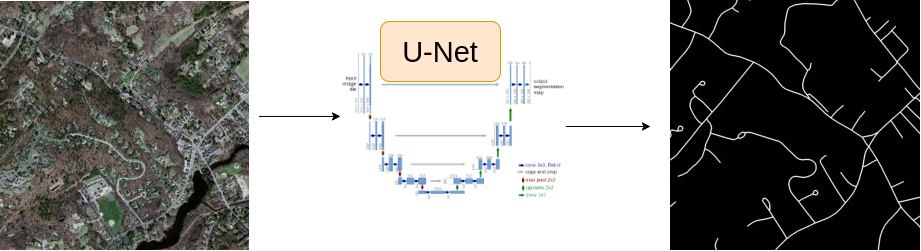

# Download Subset Dataset

In [ ]:
!git clone https://github.com/parth1620/Road_seg_dataset.git

Cloning into 'Road_seg_dataset'...
remote: Enumerating objects: 411, done.
remote: Total 411 (delta 0), reused 0 (delta 0), pack-reused 411 (from 1)
Receiving objects: 100% (411/411), 851.74 MiB | 28.74 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Updating files: 100% (401/401), done.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

# Some Common Imports

In [ ]:
import sys
sys.path.append('/content/Road_seg_dataset')

In [ ]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [ ]:
CSV_FILE='/content/Road_seg_dataset/train.csv'
data_dir= '/content/Road_seg_dataset/'
device= 'cuda'
epochs=25
batch_size=8
learning_rate=0.003
image_size=512 # size of image is 512*512
encoder='timm-efficientnet-b0'
weights='imagenet'

In [ ]:
df=pd.read_csv(CSV_FILE)
df.head()

,images,masks
0,images/17428750_15.png,masks/17428750_15.png
1,images/23279080_15.png,masks/23279080_15.png
2,images/24179185_15.png,masks/24179185_15.png
3,images/24179035_15.png,masks/24179035_15.png
4,images/11128810_15.png,masks/11128810_15.png


In [ ]:
idx=20
row =df.iloc[idx]
image_path=data_dir+row.images
mask_path=data_dir+row.masks

image=cv2.imread(image_path)
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB) #to convert into RGB format, as open csv reads images in bgr format

mask=cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)/255 # 0 for grayscale

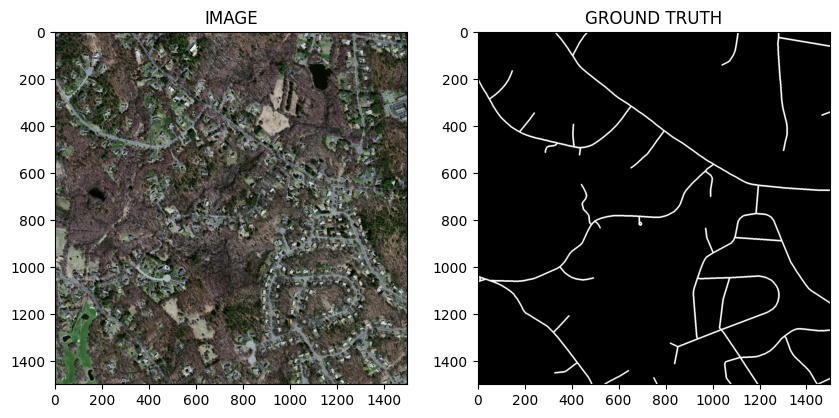

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [ ]:
train_df,valid_df=train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
len(train_df),len(valid_df)

(159, 40)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [ ]:
import albumentations as ab

In [ ]:
def get_train_augs():
  return ab.Compose([
      ab.Resize(image_size,image_size),
      ab.HorizontalFlip(p=0.5),
      ab.VerticalFlip(p=0.5)
  ])

def get_valid_augs():
  return ab.Compose([ab.Resize(image_size,image_size)])

# Task 4 : Create Custom Dataset

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class SegmentationDataset(Dataset):
  def __init__(self,df,augmentations):
    self.df=df
    self.augmentations=augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self,idx):

    row =df.iloc[idx]
    image_path=data_dir+row.images
    mask_path=data_dir+row.masks

    image=cv2.imread(image_path)
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB) #to convert into RGB format, as open csv reads images in bgr format

    mask=cv2.imread(mask_path,0)
    mask=np.expand_dims(mask,axis = -1) #(h,w,channel)

    if self.augmentations:
      data=self.augmentations(image=image,mask=mask)
      image=data['image'] #(h,w,channel)
      mask=data['mask']

    image=np.transpose(image,(2,0,1)).astype(np.float32)#(channel,h,w)
    mask=np.transpose(mask,(2,0,1)).astype(np.float32)

    image=torch.Tensor(image)/255.0
    mask=torch.round(torch.Tensor(mask)/255.0)

    return image,mask



In [ ]:
trainset=SegmentationDataset(train_df, get_train_augs())
validset=SegmentationDataset(valid_df, get_valid_augs())

In [ ]:
print(f'There are {len(trainset)} images in train set and {len(validset)} images in validation set')

There are 159 images in train set and 40 images in validation set


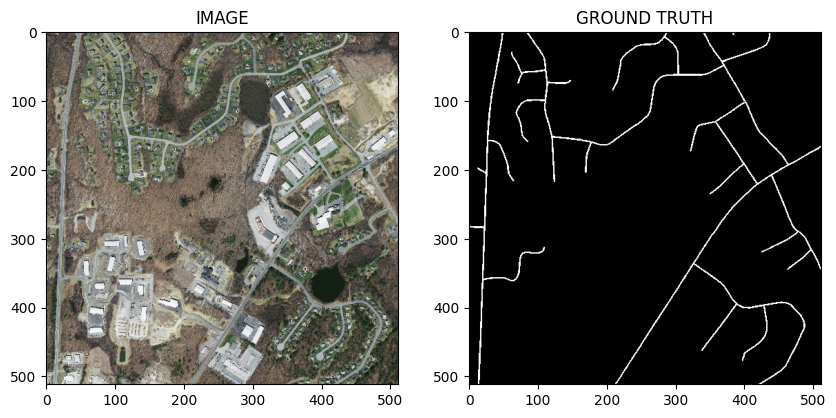

In [ ]:
idx=69
image, mask=trainset[idx]
helper.show_image(image,mask)

# Task 5 : Load dataset into batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader=DataLoader(trainset,batch_size=batch_size,shuffle=True)
validloader=DataLoader(validset,batch_size=batch_size)

In [ ]:
print(f'There are {len(trainloader)} batches in train loader and {len(validloader)} batches in validation loader')

There are 20 batches in train loader and 5 batches in validation loader


In [ ]:
for images,masks in trainloader:
  print(f"one batch image shape : {images.shape}")
  print(f"one batch mask shape : {masks.shape}")
  break

one batch image shape : torch.Size([8, 3, 512, 512])
one batch mask shape : torch.Size([8, 1, 512, 512])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [ ]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

from torch import nn

In [ ]:
class segmentationModel(nn.Module):

  def __init__(self): # first method to initialize our model
    super(segmentationModel,self).__init__()

    self.backbone=smp.Unet(
        encoder_name=encoder,
        encoder_weights=weights,
        in_channels=3,
        classes=1,
        activation=None ## this model, when will pass the image, the output will be logits.
        ##The logits are nothing but the Raw outputs without any sigmoid and softmax activation.
    )

  def forward(self,images,masks=None):

    logits = self.backbone(images)

    if masks!=None:
      return logits, DiceLoss(mode='binary')(logits,masks)+nn.BCEWithLogitsLoss()(logits, masks)

    return logits


In [ ]:
model=segmentationModel()
model.to(device)

segmentationModel(
  (backbone): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (aa): Identity()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): S

# Task 7 : Create Train and Validation Function

In [ ]:
def train_fn(dataloader,model,optimizer):
  model.train() # turn ON dropout,batchnorm,etc..

  total_train_loss=0.0

  for images,masks in tqdm(dataloader):
    images=images.to(device)
    masks=masks.to(device)

    optimizer.zero_grad()
    logits,loss=model(images,masks)
    loss.backward()
    optimizer.step()

    total_train_loss+=loss.item()

  return total_train_loss/len(dataloader)

In [ ]:
def eval_fn(dataloader,model):
  model.eval() # turn OFF dropout,batchnorm,etc..

  total_train_loss=0.0
  with torch.no_grad():
    for images,masks in tqdm(dataloader):
      images=images.to(device)
      masks=masks.to(device)

      logits,loss=model(images,masks)

      total_train_loss+=loss.item()
  return total_train_loss/len(dataloader)

# Task 8 : Train Model

In [ ]:
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)

In [ ]:
best_valid_loss=np.inf
for i in range(epochs):
  train_loss=train_fn(trainloader,model,optimizer)
  valid_loss=eval_fn(validloader,model)

  if valid_loss<best_valid_loss:
    best_valid_loss=valid_loss
    torch.save(model.state_dict(),'best_model.pt')
    print('Saved Best Model!')

  print(f'Epoch : {i+1}/{epochs}')
  print(f'Train Loss : {train_loss:.4f}')
  print(f'Valid Loss : {valid_loss:.4f}')


100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


Saved Best Model!
Epoch : 1/25
Train Loss : 1.1754
Valid Loss : 1.0102


100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


Saved Best Model!
Epoch : 2/25
Train Loss : 0.7981
Valid Loss : 0.7369


100%|██████████| 5/5 [00:04<00:00,  1.09it/s]


Saved Best Model!
Epoch : 3/25
Train Loss : 0.7220
Valid Loss : 0.6801


100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


Epoch : 4/25
Train Loss : 0.6897
Valid Loss : 0.7161


100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


Saved Best Model!
Epoch : 5/25
Train Loss : 0.6709
Valid Loss : 0.6606


100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


Epoch : 6/25
Train Loss : 0.6824
Valid Loss : 0.6955


100%|██████████| 5/5 [00:04<00:00,  1.10it/s]


Epoch : 7/25
Train Loss : 0.6716
Valid Loss : 0.6705


100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


Saved Best Model!
Epoch : 8/25
Train Loss : 0.6461
Valid Loss : 0.6415


100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


Saved Best Model!
Epoch : 9/25
Train Loss : 0.6379
Valid Loss : 0.6359


100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


Saved Best Model!
Epoch : 10/25
Train Loss : 0.6284
Valid Loss : 0.6266


100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


Saved Best Model!
Epoch : 11/25
Train Loss : 0.6328
Valid Loss : 0.5946


100%|██████████| 5/5 [00:03<00:00,  1.26it/s]


Epoch : 12/25
Train Loss : 0.6212
Valid Loss : 0.6083


100%|██████████| 5/5 [00:03<00:00,  1.28it/s]


Epoch : 13/25
Train Loss : 0.6329
Valid Loss : 0.6268


100%|██████████| 5/5 [00:03<00:00,  1.29it/s]


Epoch : 14/25
Train Loss : 0.6119
Valid Loss : 0.6051


100%|██████████| 5/5 [00:03<00:00,  1.30it/s]


Saved Best Model!
Epoch : 15/25
Train Loss : 0.6062
Valid Loss : 0.5585


100%|██████████| 5/5 [00:03<00:00,  1.29it/s]


Saved Best Model!
Epoch : 16/25
Train Loss : 0.5997
Valid Loss : 0.5536


100%|██████████| 5/5 [00:03<00:00,  1.30it/s]


Epoch : 17/25
Train Loss : 0.5996
Valid Loss : 0.6211


100%|██████████| 5/5 [00:03<00:00,  1.29it/s]


Epoch : 18/25
Train Loss : 0.5870
Valid Loss : 0.5990


100%|██████████| 5/5 [00:03<00:00,  1.29it/s]


Epoch : 19/25
Train Loss : 0.5758
Valid Loss : 0.5743


100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


Epoch : 20/25
Train Loss : 0.5825
Valid Loss : 0.5929


100%|██████████| 5/5 [00:03<00:00,  1.28it/s]


Epoch : 21/25
Train Loss : 0.5711
Valid Loss : 0.5666


100%|██████████| 5/5 [00:03<00:00,  1.30it/s]


Saved Best Model!
Epoch : 22/25
Train Loss : 0.5726
Valid Loss : 0.5397


100%|██████████| 5/5 [00:03<00:00,  1.30it/s]


Epoch : 23/25
Train Loss : 0.5819
Valid Loss : 0.6018


100%|██████████| 5/5 [00:03<00:00,  1.30it/s]


Epoch : 24/25
Train Loss : 0.5858
Valid Loss : 0.6372


100%|██████████| 5/5 [00:03<00:00,  1.29it/s]

Epoch : 25/25
Train Loss : 0.5818
Valid Loss : 0.5649


# Task 9 : Inference

In [ ]:
idx=35
model.load_state_dict(torch.load('best_model.pt'))
image,mask=validset[idx]
logits_mask=model(image.to(device).unsqueeze(0)) # unsqueeze, zero will add an extra dimension for the batch , (c,h,w)->(b,c,h,w)
pred_mask=torch.sigmoid(logits_mask)
pred_mask=(pred_mask>0.5)*1.0 # threshold value

<ipython-input-40-a06ea23d9667>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pt'))


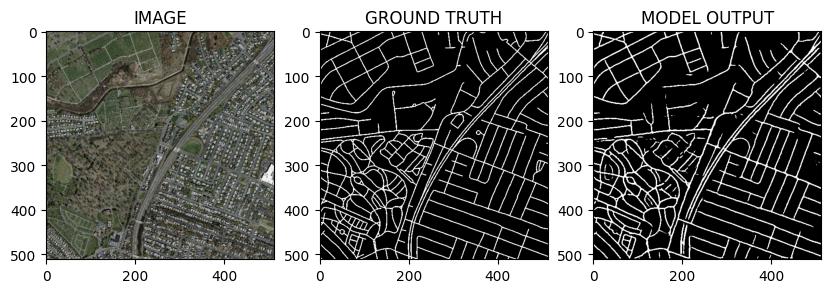

In [ ]:
Conclusion assumptionhelper.show_image(image,mask,pred_mask.detach().cpu().squeeze(0)) ##This mask is in the format of batch ,channel, height, and width we are going to remove the channel axis, we are going to remove the batch axis.